In [1]:
%pip install numpy simpy matplotlib

In [2]:
%pip install scipy

In [3]:
import pandas as pd
import scipy

In [4]:
import numpy as np
import simpy
import random
import math

class MonitoredResource(simpy.Resource):
    def __init__(self, env, capacity=1):
        super().__init__(env, capacity)
        self.env = env
        self.queue_sizes = []
        self.waiting_times = []
        self.timings = []

    def request(self, *args, **kwargs):
        req = super().request(*args, **kwargs)
        self.queue_sizes.append(len(self.queue))
        self.timings.append(self.env.now)
        req.time_queued = self.env.now
        req.callbacks.append(self._record_waiting_time)
        return req

    def _record_waiting_time(self, event):
        waiting_time = self.env.now - event.time_queued
        self.waiting_times.append(waiting_time)


class Runner(object):
    def __init__(
        self,
        env,
        name,
        running_time,
        distances,
        queues,
        usage_times,
        need_functions,
        need_satisfaction,
        average_waiting_times,
        skip_if_waiting_time_higher,
    ):
        self.env = env
        # Start the run process everytime an instance is created.
        self.running_time = running_time
        self.distances = distances
        self.queues = queues
        self.usage_times = usage_times
        self.name = name
        self.need_functions = need_functions
        self.need_satisfaction = need_satisfaction
        self.needs = {k: 0.0 for k in need_functions.keys()}
        self.previous_times = {k: env.now for k in need_functions.keys()}
        self.skip_if_waiting_time_higher = skip_if_waiting_time_higher
        self.average_waiting_times = average_waiting_times
        self.skipped_needs = {k: [] for k in need_functions.keys()}
        self.current_needs = {k: [] for k in need_functions.keys()}
        self.cummulative_usage_time = {k: 0 for k in usage_times.keys()}
        self.stop_times = []

        self.action = env.process(self.run())

    def run(self):
        # print("{} {} Start marathon".format( self.env.now, self.name))
        for i in range(0, len(self.distances)):
            # print("{} starting stage {}".format(self.env.now , i))
            yield self.env.timeout(self.running_time(self.distances[i]))
            yield from self.use_stations(i)
        self.finishing_time = self.env.now

    def use_stations(self, index):
        self.stop_times.append(self.env.now)
        for station in self.skipped_needs:
            self.skipped_needs[station].append(None)
        for station in self.needs:
            self.update_need(station)
            self.current_needs[station].append(self.needs[station])

        keys = list(self.queues[index].keys())

        random.shuffle(keys)

        for station in keys:
            yield from self.use_station(index, station)

    def use_station(self, index, station):
        skip_due_to_queue_size = (
            self.get_waiting_time(index, station)
            > self.skip_if_waiting_time_higher[station]
            and not self.needs[station] >= 1.0
        )
        if (
            random.uniform(0, 1) < self.needs[station] and not skip_due_to_queue_size
        ):  # if we want to go but have to skip
            with self.queues[index][station].request() as stn:
                yield stn
                usage_time = self.usage_times[station]()
                self.cummulative_usage_time[station] += usage_time
                yield self.env.timeout(usage_time)
            self.needs[station] = self.need_satisfaction[station](self.needs[station])
            self.previous_times[station] = self.env.now
        elif skip_due_to_queue_size:
            self.skipped_needs[station][index] = self.needs[station]

    def get_waiting_time(self, index, station):
        return (
            len(self.queues[index][station].queue) * self.average_waiting_times[station]
        )

    def update_need(self, station):
        time_difference = self.env.now - self.previous_times[station]
        self.needs[station] += self.need_functions[station](time_difference)
        self.previous_times[station] = self.env.now


marathon_distance = 42.195

average_usage_times = {
    "meal": 5,
    "water": 5,
    "toilet": 40,
    "medical": 420,
}

# skip_if_waiting_time_higher = {
#     "meal": 120,
#     "water": 120,
#     "toilet": 180,
#     "medical": 600,
# }

skip_if_waiting_time_higher = {
    "meal": math.inf,
    "water": math.inf,
    "toilet": math.inf,
    "medical": math.inf,
}

water_drinking_time = lambda: max(np.random.normal(average_usage_times["water"], 2), 1)
meal_time = lambda: max(np.random.normal(average_usage_times["meal"], 2), 1)
toilet_time = lambda: max(np.random.normal(average_usage_times["toilet"], 10), 5)
medical_time = lambda: max(np.random.normal(average_usage_times["medical"], 100), 30)

usage_times = {
    "water": water_drinking_time,
    "meal": meal_time,
    "toilet": toilet_time,
    "medical": medical_time,
}

need_functions = {
    "meal": lambda x: x / 3600.0,  # once per hour
    "water": lambda x: x / 3600.0 * 3.0,  # three times per hour
    "toilet": lambda x: x / 3600.0 / 2.0,  # once per 2 hours
    "medical": lambda x: x
    / 3600.0
    / 1000,  # over the course of the race, 1 in 5 runners needs medical attention
}

need_satisfaction = {
    "meal": lambda x: x - 1.0,
    "water": lambda x: x - 1.0,
    "toilet": lambda x: x - 1.0,
    "medical": lambda x: x - 1.0,
}

# Resources

# – Km5: WC, Water, Isotonic drink and Medical sevices
# – Km10: WC, Water, Isotonic drink and Medical sevices
# – Km 15: WC, Water, Isotonic drink, Medical sevices and Finsher Gel
# – Km 20: WC, Water, Isotonic drink, Medical sevices, Finsher Gel and Banana
# – Km 25: WC, Water, Isotonic drink, Medical sevices, Finsher Gel and Banana
# – Km 27,5: WC, Water, and Isotonic drink
# – Km 30: WC, Water, Isotonic drink, Medical sevices, Finsher Gel and Banana
# – Km 32,5: WC, Water, and Isotonic drink
# – Km 35: WC, Water, Isotonic drink, Medical sevices, Finsher Gel and Banana
# – Km 37,5: WC, Water, Isotonic drink, and Finsher Gel
# – Km 40: WC, Water, Isotonic drink, Medical sevices and Banana


def assign_resources(
    env, meal_capacities, water_capacities, toilet_capacities, medical_capacities
):
    return [
        {  # km 5
            "water": MonitoredResource(env, water_capacities[0]),
            "toilet": MonitoredResource(env, toilet_capacities[0]),
            "medical": MonitoredResource(env, medical_capacities[0]),
        },
        {  # km 10
            "water": MonitoredResource(env, water_capacities[1]),
            "toilet": MonitoredResource(env, toilet_capacities[1]),
            "medical": MonitoredResource(env, medical_capacities[1]),
        },
        {  # km 15
            "meal": MonitoredResource(env, meal_capacities[2]),
            "water": MonitoredResource(env, water_capacities[2]),
            "toilet": MonitoredResource(env, toilet_capacities[2]),
            "medical": MonitoredResource(env, medical_capacities[2]),
        },
        {  # km 20
            "meal": MonitoredResource(env, meal_capacities[3]),
            "water": MonitoredResource(env, water_capacities[3]),
            "toilet": MonitoredResource(env, toilet_capacities[3]),
            "medical": MonitoredResource(env, medical_capacities[3]),
        },
        {  # km 25
            "meal": MonitoredResource(env, meal_capacities[4]),
            "water": MonitoredResource(env, water_capacities[4]),
            "toilet": MonitoredResource(env, toilet_capacities[4]),
            "medical": MonitoredResource(env, medical_capacities[4]),
        },
        {  # km 27.5
            "water": MonitoredResource(env, water_capacities[5]),
            "toilet": MonitoredResource(env, toilet_capacities[5]),
        },
        {  # km 30
            "meal": MonitoredResource(env, meal_capacities[6]),
            "water": MonitoredResource(env, water_capacities[6]),
            "toilet": MonitoredResource(env, toilet_capacities[6]),
            "medical": MonitoredResource(env, medical_capacities[6]),
        },
        {  # km 32.5
            "water": MonitoredResource(env, water_capacities[7]),
            "toilet": MonitoredResource(env, toilet_capacities[7]),
        },
        {  # km 35
            "meal": MonitoredResource(env, meal_capacities[8]),
            "water": MonitoredResource(env, water_capacities[8]),
            "toilet": MonitoredResource(env, toilet_capacities[8]),
            "medical": MonitoredResource(env, medical_capacities[8]),
        },
        {  # km 37.5
            "meal": MonitoredResource(env, meal_capacities[9]),
            "water": MonitoredResource(env, water_capacities[9]),
            "toilet": MonitoredResource(env, toilet_capacities[9]),
        },
        {  # km 40
            "meal": MonitoredResource(env, meal_capacities[10]),
            "water": MonitoredResource(env, water_capacities[10]),
            "toilet": MonitoredResource(env, toilet_capacities[10]),
            "medical": MonitoredResource(env, medical_capacities[10]),
        },
        {},  # Finishing line
    ]


distances = [5.0, 5.0, 5.0, 5.0, 5.0, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.195]
num_stations = 11


def generate_running_function(mean_total_running_time, running_time_stddev):
    expected_finishing_time = np.random.normal(
        mean_total_running_time, running_time_stddev
    )
    return lambda distance: expected_finishing_time * distance / marathon_distance


def run_simulation_with_capacities(
    mean_total_running_time,
    usage_times,
    need_functions,
    meal_capacities,
    water_capacities,
    toilet_capacities,
    medical_capacities,
    num_runners = 8303
):
    env = simpy.Environment()
    resources = assign_resources(
        env,
        meal_capacities=meal_capacities,
        water_capacities=water_capacities,
        toilet_capacities=toilet_capacities,
        medical_capacities=medical_capacities,
    )

    running_time_stddev = 1200

    # create runners
    runners = []
    for i in range(0, num_runners):
        runners.append(
            Runner(
                env,
                name="runner %i" % i,
                running_time=generate_running_function(
                    mean_total_running_time, running_time_stddev
                ),
                distances=distances,
                queues=resources,
                usage_times=usage_times,
                need_functions=need_functions,
                need_satisfaction=need_satisfaction,
                average_waiting_times=average_usage_times,
                skip_if_waiting_time_higher=skip_if_waiting_time_higher,
            )
        )

    # running simulation
    env.run()
    return (runners, resources)


def run_simulation(
    mean_total_running_time,
    usage_times,
    need_functions,
    meal_capacity=10,
    water_capacity=10,
    toilet_capacity=10,
    medical_capacity=10,
):
    meal_capacities = [meal_capacity] * num_stations
    water_capacities = [water_capacity] * num_stations
    toilet_capacities = [toilet_capacity] * num_stations
    medical_capacities = [medical_capacity] * num_stations
    return run_simulation_with_capacities(
        mean_total_running_time,
        usage_times,
        need_functions,
        meal_capacities = meal_capacities,
        water_capacities = water_capacities,
        toilet_capacities = toilet_capacities,
        medical_capacities = medical_capacities,
    )


runners, resources = run_simulation(
    11933.0,
    usage_times,
    need_functions,
    meal_capacity=40,
    water_capacity=80,
    toilet_capacity=45,
    medical_capacity=5,
)
resource_names = ['meal', 'medical', 'toilet', 'water']


## Binary Search

In [ ]:
import copy
def queue_size_binary_search(min_allowed_max_waiting_time = 7, max_allowed_waiting_time = 15):
  base_mean_speed = 11933.0
  max_num_resources= 180
  obtained_bounds= []
  obtained_meal_capacities = []
  obtained_water_capacities = []
  obtained_toilet_capacities = []
  obtained_medical_capacities = []
  for i in range(0, num_stations):
    upper_bounds = {k: max_num_resources for k in resource_names}
    lower_bounds = {k: 1 for k in resource_names}

    has_incorrect_capacity = True
    next_tried_capacity = {}
    print("obtaining bounds for station {}". format(i))
    present_stations = []
    max_waiting_times = {}
    while has_incorrect_capacity:
      next_tried_capacity = {k: (upper_bounds[k] + lower_bounds[k]) // 2 for k in resource_names}
      # print("trying with capacities: {}".format(next_tried_capacity))
      meal_capacities = obtained_meal_capacities + [next_tried_capacity["meal"]] + [max_num_resources] * (num_stations - len(obtained_meal_capacities))
      water_capacities = obtained_water_capacities + [next_tried_capacity["water"]] + [max_num_resources] * (num_stations - len(obtained_water_capacities))
      toilet_capacities = obtained_toilet_capacities + [next_tried_capacity["toilet"]] + [max_num_resources] * (num_stations - len(obtained_toilet_capacities))
      medical_capacities = obtained_medical_capacities + [next_tried_capacity["medical"]] + [max_num_resources] * (num_stations - len(obtained_medical_capacities))
      ru, re = run_simulation_with_capacities(
          base_mean_speed,
          usage_times,
          need_functions,
          meal_capacities = meal_capacities,
          water_capacities = water_capacities,
          toilet_capacities = toilet_capacities,
          medical_capacities = medical_capacities,
          num_runners = 8303
      )
      max_waiting_times = {k: np.max(re[i][k].waiting_times + [0])  for k in re[i]}
      # Tighten the bounds based on the simulation
      has_incorrect_capacity = False
      present_stations = list(max_waiting_times.keys())
      for resource_name in max_waiting_times:
        if upper_bounds[resource_name] - lower_bounds[resource_name] <= 0:
          next_tried_capacity[resource_name]= max(upper_bounds[resource_name], lower_bounds[resource_name])
          continue
        if max_waiting_times[resource_name] > max_allowed_waiting_time:
          lower_bounds[resource_name] = next_tried_capacity[resource_name] + 1
          has_incorrect_capacity = True
        elif max_waiting_times[resource_name] < min_allowed_max_waiting_time:
          upper_bounds[resource_name] = next_tried_capacity[resource_name]
          has_incorrect_capacity = True

    print("Max waiting times {}".format(max_waiting_times))
    obtained_bounds.append({'upper': {k: upper_bounds[k] for k in present_stations}, 'lower': {k: lower_bounds[k] for k in present_stations}})
    obtained_meal_capacities.append(next_tried_capacity['meal'] if 'meal' in present_stations else None)
    obtained_water_capacities.append(next_tried_capacity['water'] if 'water' in present_stations else None)
    obtained_toilet_capacities.append(next_tried_capacity['toilet'] if 'toilet' in present_stations else None)
    obtained_medical_capacities.append(next_tried_capacity['medical'] if 'medical' in present_stations else None)

  return {
    'obtained_bounds':obtained_bounds,
    'obtained_meal_capacities': obtained_meal_capacities,
    'obtained_water_capacities': obtained_water_capacities,
    'obtained_toilet_capacities': obtained_toilet_capacities,
    'obtained_medical_capacities': obtained_medical_capacities
  }
right_sized = queue_size_binary_search()
right_sized

obtaining bounds for station 0
Max waiting times {'water': 13.427739318618706, 'toilet': 10.156931283049062, 'medical': 317.33258853964435}
obtaining bounds for station 1
Max waiting times {'water': 8.738380588527434, 'toilet': 10.213141984312642, 'medical': 0.0}
obtaining bounds for station 2
Max waiting times {'meal': 7.766025768055442, 'water': 7.991146008434043, 'toilet': 27.717124302619595, 'medical': 119.89724787608611}
obtaining bounds for station 3
Max waiting times {'meal': 3.7356856049927956, 'water': 5.6757324956633965, 'toilet': 8.59323226190736, 'medical': 135.19793161854705}
obtaining bounds for station 4
Max waiting times {'meal': 7.218114679176324, 'water': 4.988707662316301, 'toilet': 10.79451056839298, 'medical': 0.0}
obtaining bounds for station 5
Max waiting times {'water': 14.467146360173501, 'toilet': 7.741332277546462}
obtaining bounds for station 6
Max waiting times {'meal': 10.116830754761395, 'water': 7.016028285557695, 'toilet': 12.879005634191344, 'medical':

{'obtained_bounds': [{'upper': {'water': 105, 'toilet': 167, 'medical': 4},
   'lower': {'water': 103, 'toilet': 167, 'medical': 4}},
  {'upper': {'water': 53, 'toilet': 133, 'medical': 7},
   'lower': {'water': 53, 'toilet': 133, 'medical': 7}},
  {'upper': {'meal': 37, 'water': 36, 'toilet': 79, 'medical': 5},
   'lower': {'meal': 35, 'water': 35, 'toilet': 79, 'medical': 5}},
  {'upper': {'meal': 18, 'water': 27, 'toilet': 39, 'medical': 6},
   'lower': {'meal': 18, 'water': 27, 'toilet': 38, 'medical': 6}},
  {'upper': {'meal': 11, 'water': 22, 'toilet': 18, 'medical': 6},
   'lower': {'meal': 10, 'water': 22, 'toilet': 16, 'medical': 6}},
  {'upper': {'water': 21, 'toilet': 26}, 'lower': {'water': 19, 'toilet': 26}},
  {'upper': {'meal': 12, 'water': 18, 'toilet': 34, 'medical': 5},
   'lower': {'meal': 7, 'water': 18, 'toilet': 34, 'medical': 5}},
  {'upper': {'water': 17, 'toilet': 34}, 'lower': {'water': 16, 'toilet': 30}},
  {'upper': {'meal': 9, 'water': 13, 'toilet': 32, 'me

In [ ]:
right_sized

{'obtained_bounds': [{'upper': {'water': 105, 'toilet': 167, 'medical': 4},
   'lower': {'water': 103, 'toilet': 167, 'medical': 4}},
  {'upper': {'water': 53, 'toilet': 133, 'medical': 7},
   'lower': {'water': 53, 'toilet': 133, 'medical': 7}},
  {'upper': {'meal': 37, 'water': 36, 'toilet': 79, 'medical': 5},
   'lower': {'meal': 35, 'water': 35, 'toilet': 79, 'medical': 5}},
  {'upper': {'meal': 18, 'water': 27, 'toilet': 39, 'medical': 6},
   'lower': {'meal': 18, 'water': 27, 'toilet': 38, 'medical': 6}},
  {'upper': {'meal': 11, 'water': 22, 'toilet': 18, 'medical': 6},
   'lower': {'meal': 10, 'water': 22, 'toilet': 16, 'medical': 6}},
  {'upper': {'water': 21, 'toilet': 26}, 'lower': {'water': 19, 'toilet': 26}},
  {'upper': {'meal': 12, 'water': 18, 'toilet': 34, 'medical': 5},
   'lower': {'meal': 7, 'water': 18, 'toilet': 34, 'medical': 5}},
  {'upper': {'water': 17, 'toilet': 34}, 'lower': {'water': 16, 'toilet': 30}},
  {'upper': {'meal': 9, 'water': 13, 'toilet': 32, 'me

In [6]:
# right_sized_cached = {'obtained_bounds': [{'upper': {'water': 128, 'toilet': 64, 'medical': 4},
#    'lower': {'water': 64, 'toilet': 1, 'medical': 3}},
#   {'upper': {'water': 64, 'toilet': 64, 'medical': 6},
#    'lower': {'water': 32, 'toilet': 1, 'medical': 5}},
#   {'upper': {'meal': 64, 'water': 64, 'toilet': 64, 'medical': 4},
#    'lower': {'meal': 1, 'water': 1, 'toilet': 1, 'medical': 3}},
#   {'upper': {'meal': 16, 'water': 32, 'toilet': 64, 'medical': 5},
#    'lower': {'meal': 1, 'water': 16, 'toilet': 1, 'medical': 4}},
#   {'upper': {'meal': 14, 'water': 20, 'toilet': 96, 'medical': 7},
#    'lower': {'meal': 12, 'water': 18, 'toilet': 80, 'medical': 6}},
#   {'upper': {'water': 18, 'toilet': 32}, 'lower': {'water': 16, 'toilet': 1}},
#   {'upper': {'meal': 8, 'water': 16, 'toilet': 32, 'medical': 4},
#    'lower': {'meal': 1, 'water': 15, 'toilet': 1, 'medical': 3}},
#   {'upper': {'water': 16, 'toilet': 64}, 'lower': {'water': 12, 'toilet': 1}},
#   {'upper': {'meal': 10, 'water': 16, 'toilet': 32, 'medical': 7},
#    'lower': {'meal': 8, 'water': 8, 'toilet': 1, 'medical': 6}},
#   {'upper': {'meal': 8, 'water': 16, 'toilet': 32},
#    'lower': {'meal': 1, 'water': 1, 'toilet': 1}},
#   {'upper': {'meal': 8, 'water': 16, 'toilet': 32, 'medical': 6},
#    'lower': {'meal': 1, 'water': 1, 'toilet': 1, 'medical': 5}}],
#  'obtained_meal_capacities': [None, None, 32, 8, 13, None, 4, None, 9, 4, 4],
#  'obtained_water_capacities': [96, 48, 32, 24, 19, 17, 16, 14, 12, 8, 8],
#  'obtained_toilet_capacities': [32, 32, 32, 32, 88, 16, 16, 32, 16, 16, 16],
#  'obtained_medical_capacities': [4, 6, 4, 4, 6, None, 4, None, 6, None, 6]}
right_sized_cached = {'obtained_bounds': [{'upper': {'water': 105, 'toilet': 167, 'medical': 4},
   'lower': {'water': 103, 'toilet': 167, 'medical': 4}},
  {'upper': {'water': 53, 'toilet': 133, 'medical': 7},
   'lower': {'water': 53, 'toilet': 133, 'medical': 7}},
  {'upper': {'meal': 37, 'water': 36, 'toilet': 79, 'medical': 5},
   'lower': {'meal': 35, 'water': 35, 'toilet': 79, 'medical': 5}},
  {'upper': {'meal': 18, 'water': 27, 'toilet': 39, 'medical': 6},
   'lower': {'meal': 18, 'water': 27, 'toilet': 38, 'medical': 6}},
  {'upper': {'meal': 11, 'water': 22, 'toilet': 18, 'medical': 6},
   'lower': {'meal': 10, 'water': 22, 'toilet': 16, 'medical': 6}},
  {'upper': {'water': 21, 'toilet': 26}, 'lower': {'water': 19, 'toilet': 26}},
  {'upper': {'meal': 12, 'water': 18, 'toilet': 34, 'medical': 5},
   'lower': {'meal': 7, 'water': 18, 'toilet': 34, 'medical': 5}},
  {'upper': {'water': 17, 'toilet': 34}, 'lower': {'water': 16, 'toilet': 30}},
  {'upper': {'meal': 9, 'water': 13, 'toilet': 32, 'medical': 9},
   'lower': {'meal': 7, 'water': 13, 'toilet': 30, 'medical': 9}},
  {'upper': {'meal': 5, 'water': 11, 'toilet': 28},
   'lower': {'meal': 4, 'water': 10, 'toilet': 27}},
  {'upper': {'meal': 5, 'water': 11, 'toilet': 18, 'medical': 8},
   'lower': {'meal': 5, 'water': 11, 'toilet': 18, 'medical': 8}}],
 'obtained_meal_capacities': [None, None, 36, 18, 10, None, 9, None, 8, 4, 5],
 'obtained_water_capacities': [104, 53, 35, 27, 22, 20, 18, 16, 13, 10, 11],
 'obtained_toilet_capacities': [167, 133, 79, 38, 17, 26, 34, 32, 31, 27, 18],
 'obtained_medical_capacities': [4, 7, 5, 6, 6, None, 5, None, 9, None, 8]}

In [ ]:
#right_sized_cached = right_sized # comment this in case you want to use cached values

In [ ]:
sum(right_sized_cached['obtained_toilet_capacities'])

602

## Latex

In [ ]:
only_capacities = {k:v for k,v in right_sized_cached.items() if k != 'obtained_bounds'}
print(pd.DataFrame(only_capacities).to_latex())

\begin{tabular}{lrrrr}
\toprule
 & obtained_meal_capacities & obtained_water_capacities & obtained_toilet_capacities & obtained_medical_capacities \\
\midrule
0 & NaN & 104 & 167 & 4.000000 \\
1 & NaN & 53 & 133 & 7.000000 \\
2 & 36.000000 & 35 & 79 & 5.000000 \\
3 & 18.000000 & 27 & 38 & 6.000000 \\
4 & 10.000000 & 22 & 17 & 6.000000 \\
5 & NaN & 20 & 26 & NaN \\
6 & 9.000000 & 18 & 34 & 5.000000 \\
7 & NaN & 16 & 32 & NaN \\
8 & 8.000000 & 13 & 31 & 9.000000 \\
9 & 4.000000 & 10 & 27 & NaN \\
10 & 5.000000 & 11 & 18 & 8.000000 \\
\bottomrule
\end{tabular}



## Repeated Runs

In [ ]:
def obtain_repeated_results(num_runs = 3):
  results = []
  base_mean_speed = 11933.0

  for i in range(0, num_runs):
    print('.', end='')
    ru,re = run_simulation_with_capacities(
      base_mean_speed,
      usage_times,
      need_functions,
      meal_capacities=right_sized_cached['obtained_meal_capacities'],
      water_capacities=right_sized_cached['obtained_water_capacities'],
      toilet_capacities=right_sized_cached['obtained_toilet_capacities'],
      medical_capacities=right_sized_cached['obtained_medical_capacities']
    )
    results.append({'resources': re, 'runners': ru})
  return results
repeated_executions = obtain_repeated_results(50)

..................................................

## Linear Model

In [7]:
linear_factors = {
      'humidity': {
          'medium': 0.08 * 60,
          'high': 0.56 * 60
      },
      'temperature': {
          'medium': 0.04 * 60,
          'high': 1.87 * 60
      },
      'wind': {
          'medium': 1.51 * 60,
          'high': 1.35 * 60
      }
  }

conditions_2017_marathon = {
    'humidity': 'medium',
    'temperature': 'medium',
    'wind': 'medium'
}

def run_linear_simulation(h, t, w):
  base_mean_speed = 11933.0 - sum([linear_factors[k][v] for k,v in conditions_2017_marathon.items()])
  mean_speed = base_mean_speed + linear_factors['humidity'][h]+ linear_factors['temperature'][t]+ linear_factors['wind'][w]

  meal_capacity = 40
  water_capacity = 80
  toilet_capacity = 45
  medical_capacity = 5


  ru, re = run_simulation_with_capacities(
      mean_speed,
      usage_times,
      need_functions,
      meal_capacities=right_sized_cached['obtained_meal_capacities'],
      water_capacities=right_sized_cached['obtained_water_capacities'],
      toilet_capacities=right_sized_cached['obtained_toilet_capacities'],
      medical_capacities=right_sized_cached['obtained_medical_capacities']
    )
  return{
      'humidity': h,
      'temperature': t,
      'wind': w,
      'runners': ru,
      'resources': re
  }

def obtain_linear_results():
  results = []

  for h in linear_factors['humidity']:
    for t in linear_factors['temperature']:
      for w in linear_factors['wind']:
        results.append(run_linear_simulation(h,t,w))

  return results

linear_results = obtain_linear_results()

# Statistical Helpers

In [8]:
import pandas as pd
import scipy


In [9]:
import types

no_waiting = types.SimpleNamespace()
no_waiting.waiting_times = [0]

def waiting_times(resources, station):
  return [ q.get(station, no_waiting).waiting_times for q in resources  ]

In [10]:
def runners_needs(runners, resource_name):
  return [
    [runner.current_needs[resource_name][i] for runner in runners ]
    for i in range(0, len(runners[0].current_needs[resource_name]))
  ]

def median_need_by_station(runners, resource_names):
  return {resource_name: [np.median(station_needs) for station_needs in runners_needs(runners, resource_name)] for resource_name in resource_names}

In [11]:
def runners_skipped_resource(runners, resource_name):
  skipped = [ [1 if need != None else 0 for need in runner.skipped_needs[resource_name] ] for runner in runners]
  return np.sum(skipped, axis=0)

def total_skipped_by_station(runners, resource_names):
  return {resource_name: runners_skipped_resource(runners, resource_name) for resource_name in resource_names}

In [12]:
def num_users(resources, resource_name):
  return [len(resource[resource_name].waiting_times) if resource_name in resource else 0 for resource in resources]

In [13]:
def compute_resource_statistics(resources, resource_name):
  w = waiting_times(resources, resource_name)
  non_empty_w = filter(lambda q: len(q) > 0,w)
  flattened_w = [t for q in w for t in q ]
  return {
    'resource': resource_name,
    'max queue': (np.max(flattened_w)),
    'max median queue': (np.max([np.median(q) for q in non_empty_w])),
    'average overall': (np.mean(flattened_w))
  }

# Analyze Repeated Executions

In [14]:
def obtain_repeated_data_frame(repeated_results, resource_name):
  stats = [compute_resource_statistics(r['resources'], resource_name) for r in repeated_results]
  return pd.DataFrame(stats)

In [15]:
repeated_data_frames = {k: obtain_repeated_data_frame(repeated_executions, k) for k in resource_names}

NameError: name 'repeated_executions' is not defined

In [ ]:
repeated_data_frames['water'].describe()

In [ ]:
repeated_data_frames['meal'].describe()

In [ ]:
repeated_data_frames['medical'].describe()

In [ ]:
repeated_data_frames['toilet'].describe()

In [ ]:
for resource_name in resource_names:
  shapiro_test_result = scipy.stats.shapiro(obtain_repeated_data_frame(repeated_executions, resource_name)['max queue'])
  print(resource_name)
  print(shapiro_test_result)


In [ ]:
standard_deviations = {k:repeated_data_frames[k]['max queue'].std()  for k in repeated_data_frames}
standard_deviations

In [ ]:
all_summaries = []
for k in repeated_data_frames:
  summary = repeated_data_frames[k].describe().reset_index()
  summary.insert(0,'resource', k)
  all_summaries.append(summary)
all_summaries = pd.concat(all_summaries)
all_summaries = all_summaries.rename(columns={'index':'statistic'})
all_summaries

## Latex


In [ ]:
def print_latex_statistic(stat_name):
  df = all_summaries[all_summaries['statistic'] == stat_name]
  print(df.loc[:, df.columns != 'statistic'].to_latex(index=False, float_format="%.2f", escape=True))

In [ ]:
print_latex_statistic('50%')

In [ ]:
print_latex_statistic('max')

In [ ]:
print_latex_statistic('std')

In [ ]:
print_latex_statistic('mean')

In [ ]:
for k in repeated_data_frames:
  print("\\begin{table}")
  print(repeated_data_frames[k].describe().to_latex())
  print("\\caption{Statistical summary for %s resources in repeated runs}"%k)
  print("\\label{tab:statistics-%s}" % k)
  print("\\end{table}\n\n")


# Analyze Linear Model Results

In [16]:
linear_factors = ['humidity', 'wind', 'temperature']
def compute_linear_model_resource_statistics():
  columns = linear_factors + ['resource', 'max queue', 'max median queue', 'average overall']
  columns = {c: [] for c in columns }
  for r in linear_results:
    for resource_name in resource_names:
      for f in linear_factors:
        columns[f].append(r[f])
      stats = compute_resource_statistics(r['resources'], resource_name)
      for k in stats:
        columns[k].append(stats[k])
  return columns

def compute_linear_model_runner_statistics():
  columns = linear_factors + ['mean finish time', 'mean expected finish time']
  columns = {c: [] for c in columns }
  for r in linear_results:
    for f in linear_factors:
      columns[f].append(r[f])
    columns['mean finish time'].append(np.mean([runner.finishing_time for runner in r['runners']]))
    expected_finishing_times = [runner.running_time(marathon_distance) for runner in r['runners']]
    columns['mean expected finish time'].append(np.mean(expected_finishing_times))
  return columns
lin_resource_stats = pd.DataFrame(compute_linear_model_resource_statistics())
lin_runner_stats = pd.DataFrame(compute_linear_model_runner_statistics())

In [17]:
lin_runner_stats

,humidity,wind,temperature,mean finish time,mean expected finish time
0,medium,medium,medium,12099.616824,11933.998461
1,medium,high,medium,12090.304066,11924.361357
2,medium,medium,high,12198.125232,12034.062107
3,medium,high,high,12209.372096,12043.155509
4,high,medium,medium,12143.427079,11975.476785
5,high,high,medium,12101.574470,11938.360595
6,high,medium,high,12249.046515,12079.432908
7,high,high,high,12215.618512,12049.778100


In [44]:
print(lin_runner_stats.to_latex(index=False, float_format="%.0f"))

\begin{tabular}{lllrr}
\toprule
humidity & wind & temperature & mean finish time & mean expected finish time \\
\midrule
medium & medium & medium & 12100 & 11934 \\
medium & high & medium & 12090 & 11924 \\
medium & medium & high & 12198 & 12034 \\
medium & high & high & 12209 & 12043 \\
high & medium & medium & 12143 & 11975 \\
high & high & medium & 12102 & 11938 \\
high & medium & high & 12249 & 12079 \\
high & high & high & 12216 & 12050 \\
\bottomrule
\end{tabular}



In [19]:
print(lin_resource_stats.sort_values(['resource', 'humidity', 'wind', 'temperature'], ascending = [True, False, False, False]).to_latex())

\begin{tabular}{lllllrrr}
\toprule
 & humidity & wind & temperature & resource & max queue & max median queue & average overall \\
\midrule
0 & medium & medium & medium & meal & 17.945551 & 0.000000 & 0.676546 \\
8 & medium & medium & high & meal & 15.720336 & 0.000000 & 0.781867 \\
4 & medium & high & medium & meal & 13.539771 & 0.000000 & 0.544913 \\
12 & medium & high & high & meal & 11.079675 & 0.000000 & 0.657496 \\
16 & high & medium & medium & meal & 27.912122 & 0.000000 & 1.161118 \\
24 & high & medium & high & meal & 12.953479 & 0.000000 & 0.798023 \\
20 & high & high & medium & meal & 14.333784 & 0.000000 & 0.755675 \\
28 & high & high & high & meal & 15.300285 & 0.000000 & 0.843992 \\
1 & medium & medium & medium & medical & 161.059636 & 0.000000 & 1.425307 \\
9 & medium & medium & high & medical & 181.231188 & 0.000000 & 3.315849 \\
5 & medium & high & medium & medical & 191.071797 & 0.000000 & 3.059162 \\
13 & medium & high & high & medical & 129.447704 & 0.000000 & 5.3784

In [20]:
lin_resource_stats[lin_resource_stats['resource'] == 'water']

,humidity,wind,temperature,resource,max queue,max median queue,average overall
3,medium,medium,medium,water,19.669383,2.297932,1.510053
7,medium,high,medium,water,17.348217,0.000000,1.485368
11,medium,medium,high,water,16.502543,0.367781,1.276362
15,medium,high,high,water,20.827540,0.055214,1.613987
19,high,medium,medium,water,15.016257,0.362603,1.621825
23,high,high,medium,water,20.494153,0.134204,1.346140
27,high,medium,high,water,22.458124,0.365250,1.641125
31,high,high,high,water,17.284359,0.234861,1.248177


In [21]:
lin_resource_stats[lin_resource_stats['resource'] == 'meal']

,humidity,wind,temperature,resource,max queue,max median queue,average overall
0,medium,medium,medium,meal,17.945551,0.0,0.676546
4,medium,high,medium,meal,13.539771,0.0,0.544913
8,medium,medium,high,meal,15.720336,0.0,0.781867
12,medium,high,high,meal,11.079675,0.0,0.657496
16,high,medium,medium,meal,27.912122,0.0,1.161118
20,high,high,medium,meal,14.333784,0.0,0.755675
24,high,medium,high,meal,12.953479,0.0,0.798023
28,high,high,high,meal,15.300285,0.0,0.843992


In [22]:
lin_resource_stats[lin_resource_stats['resource'] == 'toilet']

,humidity,wind,temperature,resource,max queue,max median queue,average overall
2,medium,medium,medium,toilet,40.092755,2.060790,2.453263
6,medium,high,medium,toilet,42.564427,2.316275,2.785009
10,medium,medium,high,toilet,21.841315,0.000000,1.345911
14,medium,high,high,toilet,25.062501,2.127531,1.689117
18,high,medium,medium,toilet,20.197100,0.000000,1.492620
22,high,high,medium,toilet,19.302431,0.000000,1.328739
26,high,medium,high,toilet,28.530716,3.570917,2.903518
30,high,high,high,toilet,49.392987,7.216872,2.840634


In [23]:
lin_resource_stats[lin_resource_stats['resource'] == 'medical']

,humidity,wind,temperature,resource,max queue,max median queue,average overall
1,medium,medium,medium,medical,161.059636,0.000000,1.425307
5,medium,high,medium,medical,191.071797,0.000000,3.059162
9,medium,medium,high,medical,181.231188,0.000000,3.315849
13,medium,high,high,medical,129.447704,0.000000,5.378482
17,high,medium,medium,medical,416.804684,80.951358,25.249765
21,high,high,medium,medical,162.386682,0.000000,3.927742
25,high,medium,high,medical,153.627642,0.000000,3.995360
29,high,high,high,medical,319.328649,24.609166,17.332563


# Plot Data

## Obtain Example Run

In [24]:
# _r = obtain_repeated_results(num_runs = 1)[0]
# resources = _r['resources']
# runners = _r['runners']

baseline_water = math.ceil(sum(right_sized_cached['obtained_water_capacities']) / 11)
baseline_toilet = math.ceil(sum(right_sized_cached['obtained_toilet_capacities']) / 11)
baseline_meal = math.ceil(sum([ i for i in right_sized_cached['obtained_meal_capacities'] if i != None]) / 7)
baseline_medical = math.ceil(sum([ i for i in right_sized_cached['obtained_medical_capacities'] if i != None]) / 8)

print("baseline params per station:")
print("water: {}".format(baseline_water))
print("toilet: {}".format(baseline_toilet))
print("meal: {}".format(baseline_meal))
print("medical: {}".format(baseline_medical))

runners, resources = run_simulation(
    11933.0,
    usage_times,
    need_functions,
    meal_capacity=baseline_meal,
    water_capacity=baseline_water,
    toilet_capacity=baseline_toilet,
    medical_capacity=baseline_medical,
)

baseline params per station:
water: 30
toilet: 55
meal: 13
medical: 7


## Compute Data

In [25]:
num_users_by_station = pd.DataFrame({k: num_users(resources, k) for k in resource_names})


In [26]:
sum(num_users(resources, 'medical'))

129

In [27]:
median_needs = pd.DataFrame(median_need_by_station(runners, resource_names))
total_skipped = pd.DataFrame(total_skipped_by_station(runners, resource_names))

In [28]:
finishing_times= [runner.finishing_time for runner in runners]
expected_finishing_times = [runner.running_time(marathon_distance) for runner in runners]

## Actual plots

In [29]:
import matplotlib.pyplot as plt

In [30]:
from google.colab import files
def download_plot(name):
  plt.savefig(name)
  files.download(name)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

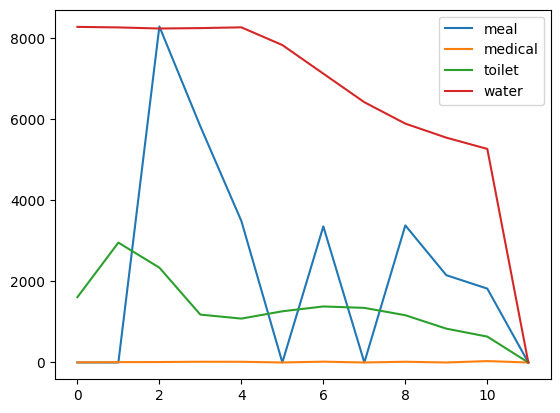

In [31]:
plt.figure()
num_users_by_station.plot()
download_plot('users-by-station.pdf')

(array([  12.,  125.,  652., 1290., 1576., 1662., 1498., 1112.,  362.,
          14.]),
 array([ 7428.38060084,  8450.0614695 ,  9471.74233817, 10493.42320684,
        11515.10407551, 12536.78494418, 13558.46581285, 14580.14668152,
        15601.82755018, 16623.50841885, 17645.18928752]),
 <BarContainer object of 10 artists>)

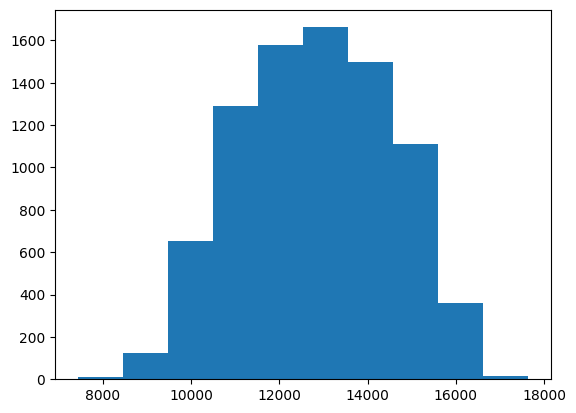

In [32]:
plt.hist(finishing_times)


(array([  10.,   89.,  521., 1483., 2530., 2192., 1109.,  330.,   35.,
           4.]),
 array([ 7337.84888985,  8289.88631129,  9241.92373273, 10193.96115416,
        11145.9985756 , 12098.03599704, 13050.07341848, 14002.11083991,
        14954.14826135, 15906.18568279, 16858.22310422]),
 <BarContainer object of 10 artists>)

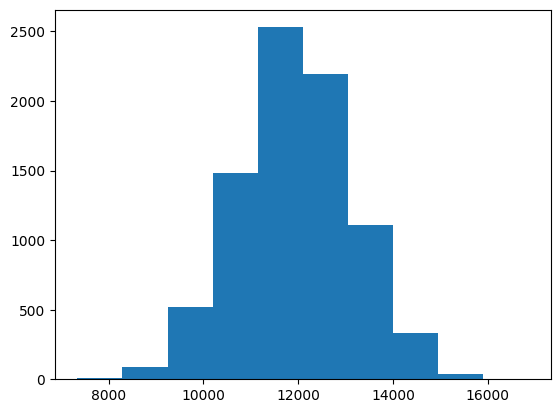

In [33]:

plt.hist(expected_finishing_times)

In [34]:
print("min actual: {}  min expected: {}".format( min(finishing_times), min(expected_finishing_times)))
print("max actual: {}  max expected: {}".format( max(finishing_times), max(expected_finishing_times)))

min actual: 7428.380600835166  min expected: 7337.848889853133
max actual: 17645.189287520683  max expected: 16858.223104224904


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

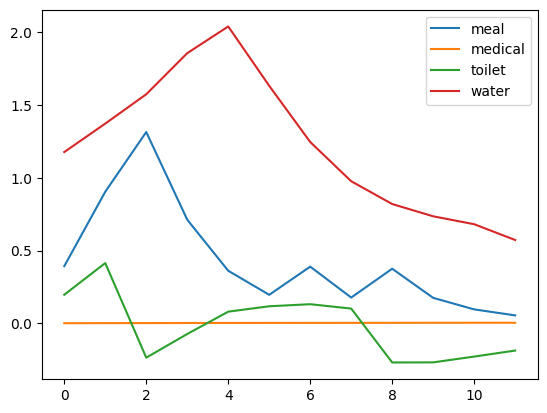

In [35]:
# total_skipped.plot()
median_needs.plot()
download_plot("median-needs.pdf")

(array([1419.,  727.,  611.,  606.,  629.,  594.,  628.,  710.,  822.,
        1528.]),
 array([  0.        ,  73.49855014, 146.99710028, 220.49565042,
        293.99420057, 367.49275071, 440.99130085, 514.48985099,
        587.98840113, 661.48695127, 734.98550142]),
 <BarContainer object of 10 artists>)

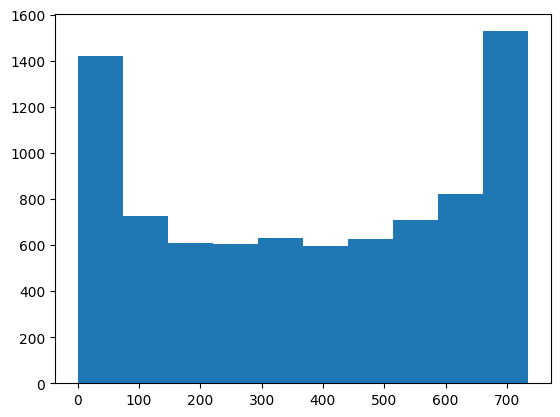

In [36]:
import matplotlib as mpl

mpl.pyplot.hist(resources[0]['water'].waiting_times)


<Axes: >

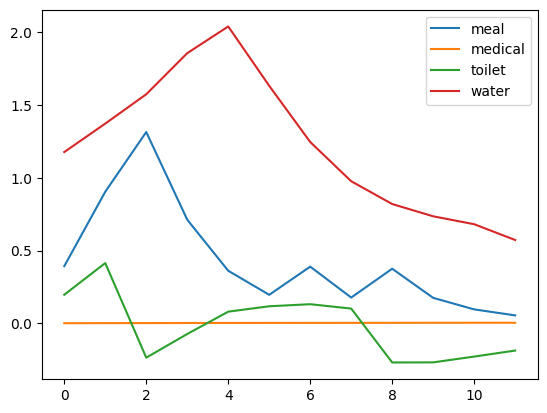

In [37]:

import statistics

fig, ax = plt.subplots()
median_needs.plot(ax= ax)


In [38]:
list(map(len, waiting_times(resources, 'medical')))

[3, 8, 11, 18, 17, 1, 20, 1, 18, 1, 34, 1]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

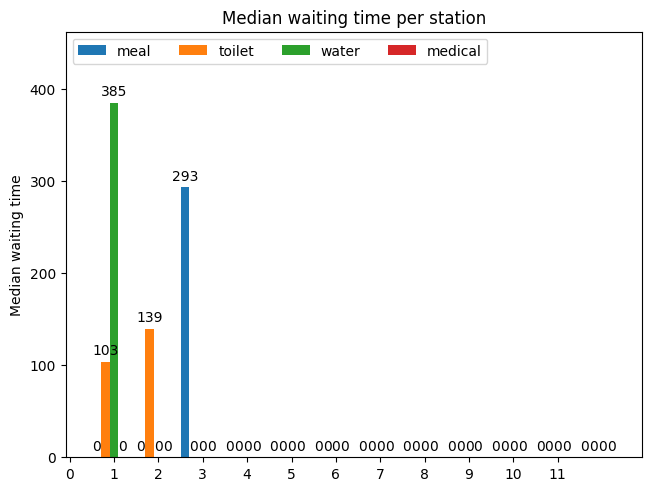

In [39]:
stations = list(usage_times.keys())
median_wait = {
    'meal': [statistics.median(t) for t in waiting_times(resources, 'meal')],
    'toilet': [statistics.median(t) for t in waiting_times(resources, 'toilet')],
    'water': [statistics.median(t) for t in waiting_times(resources, 'water')],
    'medical': [statistics.median(t) if len(t) > 0 else 0 for t in waiting_times(resources, 'medical')],
}

x = np.arange(len(median_wait['water']))  # the label locations
width = 1.0/ (len(stations) + 1.0)  # the width of the bars
multiplier = len(median_wait.keys())

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in median_wait.items():
    offset = width * multiplier
    rects = ax.bar(x  + offset, measurement, width, label=attribute)
    ax.bar_label(rects, fmt="%i", padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Median waiting time')
ax.set_title('Median waiting time per station')
ax.set_xticks(x + width, x)
ax.legend(loc='upper left', ncols=4)
ax.margins(0.05, 0.2)


download_plot("median-wait-per-station.pdf")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

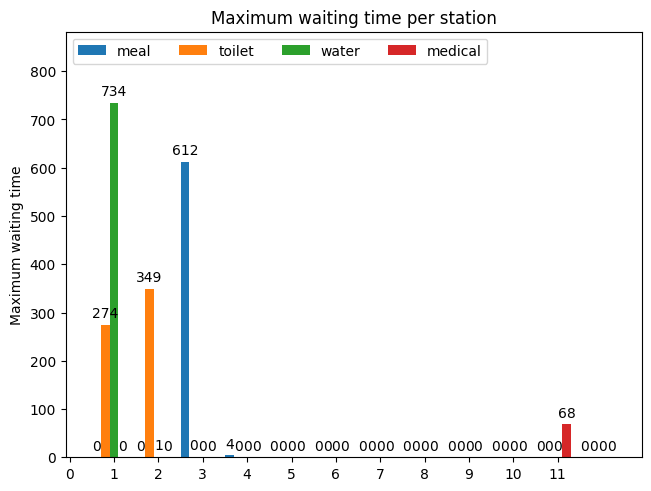

In [40]:

stations = list(usage_times.keys())
median_wait = {
    'meal': [np.max(t) for t in waiting_times(resources, 'meal')],
    'toilet': [np.max(t) for t in waiting_times(resources, 'toilet')],
    'water': [np.max(t) for t in waiting_times(resources, 'water')],
    'medical': [np.max(t) if len(t) > 0 else 0 for t in waiting_times(resources, 'medical')],
}

x = np.arange(len(median_wait['water']))  # the label locations
width = 1.0/ (len(stations) + 1.0)  # the width of the bars
multiplier = len(median_wait.keys())

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in median_wait.items():
    offset = width * multiplier
    rects = ax.bar(x  + offset, measurement, width, label=attribute)
    ax.bar_label(rects, fmt="%i", padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Maximum waiting time')
ax.set_title('Maximum waiting time per station')
ax.set_xticks(x + width, x)
ax.legend(loc='upper left', ncols=4)
ax.margins(0.05, 0.2)

download_plot("maximum-waiting-times.pdf")

In [41]:
median_wait

{'meal': [0,
  0,
  612.4059220639319,
  4.605198787689005,
  0.5706547925510677,
  0,
  0.4393456095294823,
  0,
  0.0,
  0.0,
  0.0,
  0],
 'toilet': [274.7014080136362,
  349.11314711058003,
  0.8399519807717297,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0],
 'water': [734.9855014164743,
  1.0084508381814885,
  0.43136074873018515,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0],
 'medical': [0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 0, 0.0, 0, 68.37298700679821, 0]}

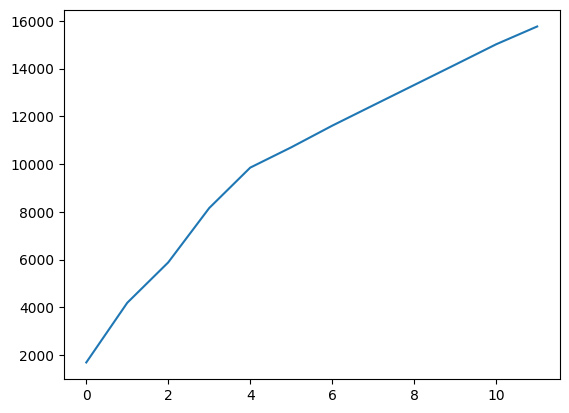

In [42]:
plt.plot(runners[10].stop_times)